<a href="https://colab.research.google.com/github/tucosh/kaggle/blob/main/tensorflow_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

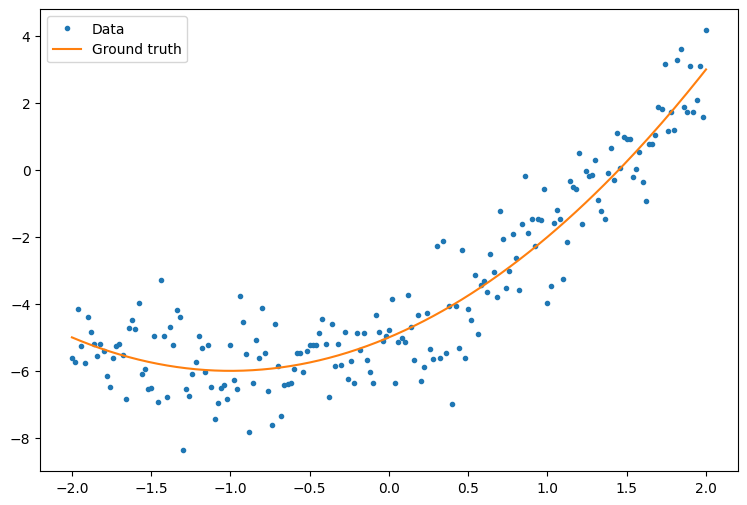

In [10]:
# From https://www.tensorflow.org/guide/basics#training_loops

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
matplotlib.rcParams['figure.figsize'] = [9,6]


# 1-d array of 201 points from -2.0 to 2.0
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x, y, '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend()
# plt.show()

In [61]:

# Create a quadratic model with randomly initialised weights and a bias

# https://www.tensorflow.org/api_docs/python/tf/Module
class Model(tf.Module):
  def __init__(self):
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic model:
    return self.w_q * (x**2) + self.w_l * x + self.b

  @property
  def weights(self):
    return f'w_q: {self.w_q.numpy():0.6f} w_l: {self.w_l.numpy():0.6f} b: {self.b.numpy():0.6f}'

quad_model = Model()
print('Initial weights: ', quad_model.weights)

Initial weights:  w_q: 4.568467 w_l: 1.809872 b: 3.010204


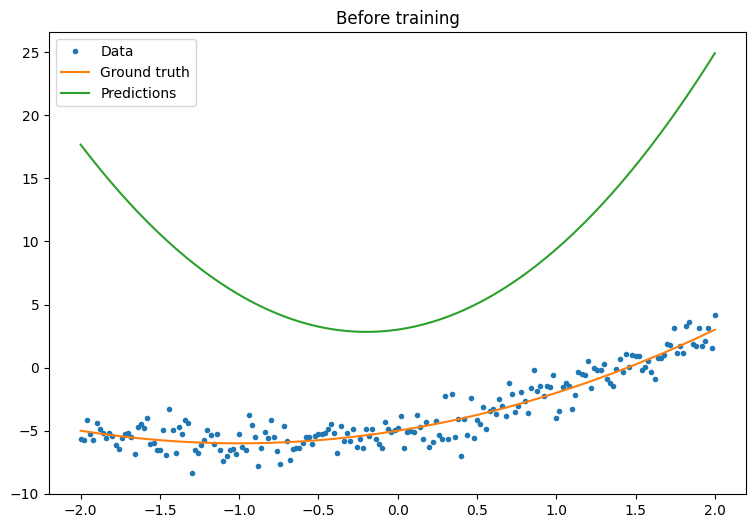

In [62]:

# Observe model's performance before training.
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.legend()
  plt.title(title)

plot_preds(x, y, f, quad_model, 'Before training')

Epoch 0: loss = 65.467
w_q: 2.062586 w_l: 1.917643 b: 1.539633
Epoch 10: loss = 4.894
w_q: -0.320285 w_l: 2.008272 b: -2.046486
Epoch 20: loss = 2.321
w_q: 0.225364 w_l: 2.004661 b: -3.253976
Epoch 30: loss = 1.408
w_q: 0.548635 w_l: 2.016671 b: -3.976951
Epoch 40: loss = 1.088
w_q: 0.744837 w_l: 2.024750 b: -4.405622
Epoch 50: loss = 0.975
w_q: 0.873213 w_l: 2.017114 b: -4.656566
Epoch 60: loss = 0.938
w_q: 0.931842 w_l: 2.014990 b: -4.799544
Epoch 70: loss = 0.924
w_q: 0.980944 w_l: 2.012913 b: -4.889960
Epoch 80: loss = 0.920
w_q: 0.986371 w_l: 2.017294 b: -4.942669
Epoch 90: loss = 0.919
w_q: 1.028197 w_l: 2.014698 b: -4.954679




Text(0.5, 1.0, 'MSE Loss vs training iterations')

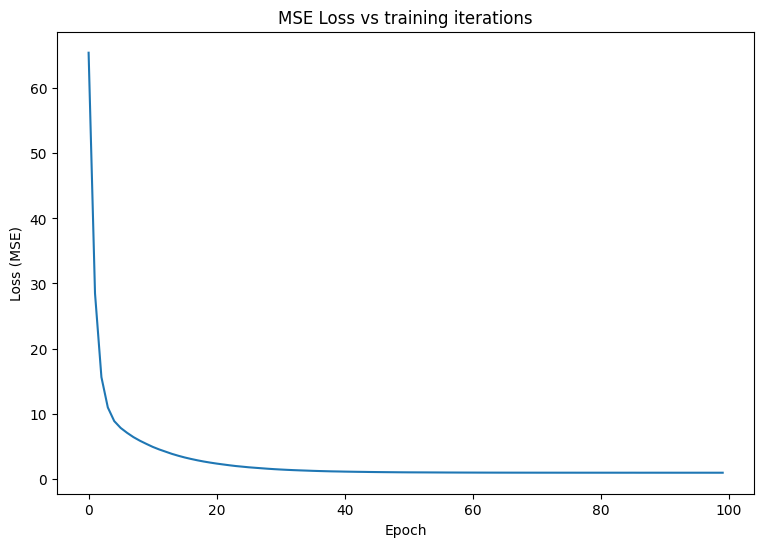

In [63]:

# Use Mean Squared Error as loss function.
def mse_loss (y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

batch_size = 32
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g, v in zip(grads, quad_model.variables):
      # update model's variables here
      v.assign_sub(learning_rate * g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Epoch {epoch}: loss = {loss.numpy():0.3f}')
    print(quad_model.weights)


# Plot model results
print('\n')
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('MSE Loss vs training iterations')

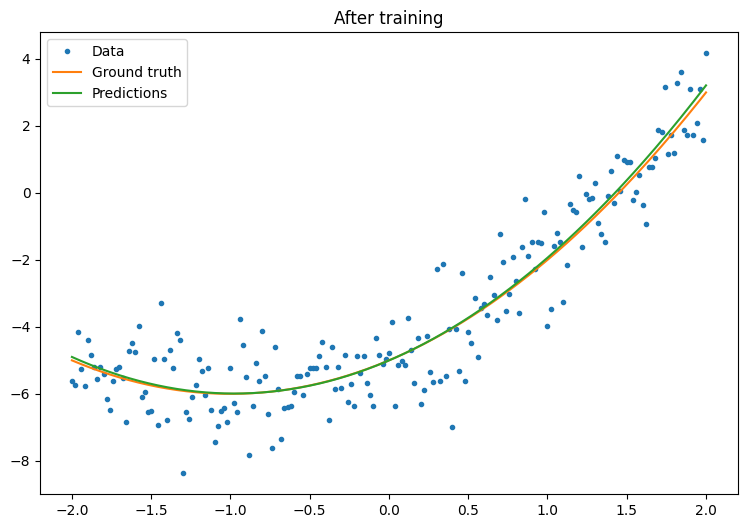

In [24]:

# Observe model's performance after training
plot_preds(x, y, f, quad_model, 'After training')

In [65]:

# Now reimplement the model using Keras

new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])



new_model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.MSE)

history = new_model.fit(x, y, epochs=100, batch_size=32, verbose=0)

In [66]:
new_model.variables

[<KerasVariable shape=(2, 1), dtype=float32, path=sequential_2/dense_2/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_2/dense_2/bias>]

Text(0.5, 1.0, 'MSE Loss vs training iterations')

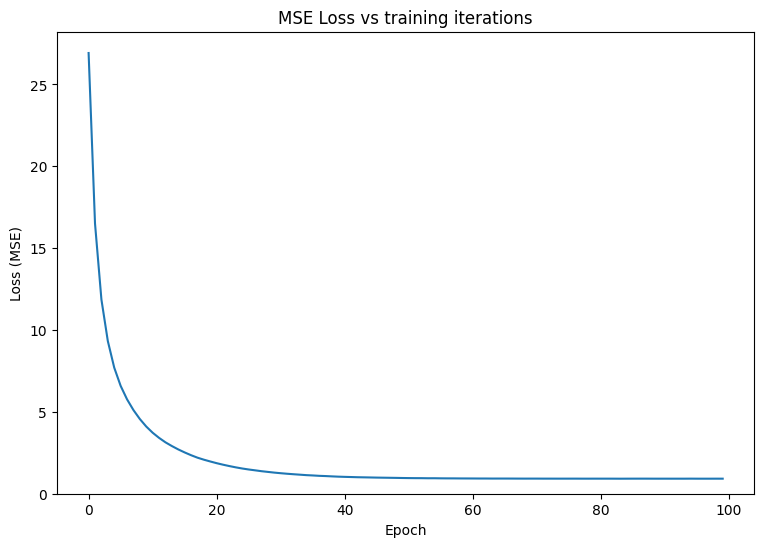

In [27]:

plt.plot(range(100), history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss (MSE)')
plt.title('MSE Loss vs training iterations')

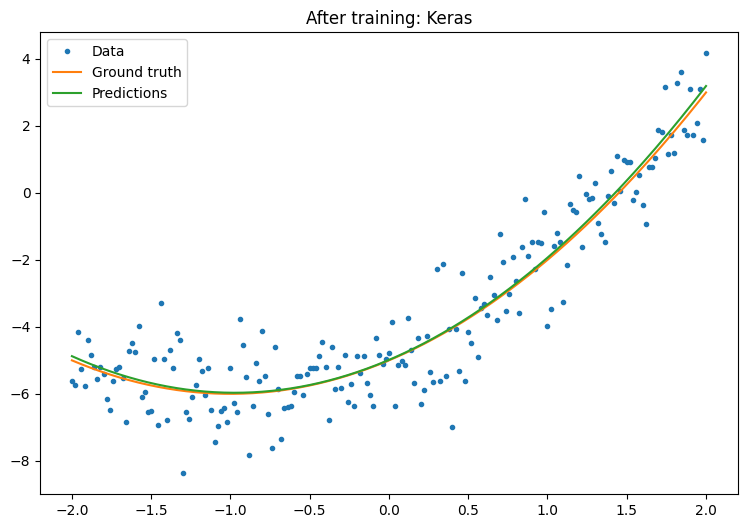

In [28]:

plot_preds(x, y, f, new_model, 'After training: Keras')